## Importowanie bibliotek
Biblioteka `morfeusz2` posłuży do lematyzacji, `plwordnet` i Słowosieć do analizy sentymentu. 

>**Słowosieć** (ang. PlWordNet) – baza danych leksykalno-semantycznych języka polskiego typu wordnet. Zawiera zestawy synonimicznych jednostek leksykalnych (synsety) opisanych krótkimi definicjami. Słowosieć służy jako słownik, w którym pojęcia (synsety) i poszczególne znaczenia wyrazów (jednostki leksykalne) zdefiniowane są poprzez miejsce w sieci wzajemnych relacji, odzwierciedlających system leksykalny polszczyzny. Słowosieć jest także wykorzystywana jako jeden z podstawowych zasobów do budowy programów przetwarzających język polski. ([Wikipedia](https://pl.wikipedia.org/wiki/S%C5%82owosie%C4%87))


- http://morfeusz.sgjp.pl/download/
- https://slowosiec.pl/

In [1]:
# import plwordnet
import morfeusz2
import pandas as pd
import numpy as np

In [2]:
# biblioteki do wizualizacji danych
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib_inline.backend_inline import set_matplotlib_formats
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from PIL import Image

set_matplotlib_formats('svg')

## Opis danych
Dane pochodzą z Reddita i Wykopu, zostały one zescrapowane przy uwzględnieniu następujących tagów: 
>wybory,prezydent,prezydenckie,debata,prezydencka,
>Zandberg,Biejat,Nawrocki,Trzaskowski,Hołownia,Mentzen,Braun,
>Maciak,Woch,Jakubiak,Senyszyn,Bartoszewicz,Stanowski,Końskie

[Nasza dokumentacja procesu webscrapingu](https://github.com/dpiotrkowski/PSI-analiza-sentymentu/blob/main/src/README.md)

![](raport/img/loga.png)

## Wstępne przetwarzanie tekstu
W tym punkcie podejmiemy następujące kroki:
1. Usunięcie niepotrzebnych znaków z tekstu źródłowego
2. Autokorekta tekstu
3. Lematyzacja za pomocą Morfeusza
4. Usunięcie stop słów z lematów
   
Na początku załadujmy polski słownik sentymentu (ręcznie przefiltrowany `plwordnet` w csv). 

In [3]:
slownik_sentymentu = pd.read_csv('słowniki/SłownikSentymentu.csv', sep=';',encoding='cp1250')
# print(slownik_sentymentu.columns.tolist())

Wczytujemy zescrapowane pliki tekstowe z Reddita/Wykopu.

In [4]:
with open('data/results_reddit.txt', 'r', encoding='utf-8') as file:
    reddit_messy = file.read()
with open('data/results_wykop.txt', 'r', encoding='utf-8') as file:
    wykop_messy = file.read()

Kolejnym krokiem będzie przeczyszczenie wczytanego tekstu, czyli:
- usunięcie znaków interpunkcyjnych
- usunięcie niepożądanych słów z tekstu źródłowego
- usunięcie wszystkich linków z wpisów
- usunięcie tagów (`#` popularne na Wykopie)
- usunięcie liczb
- usunięcie polskich stop słów

### 1. Czyszczenie tekstu

Funkcja `text_roomba` dokładnie czyści tekst oraz dzieli go na pojedyncze słowa.

In [5]:
niechciane_slowa = [
    'r/', 'Tytuł', 'tytuł', 'Treść', 'treść', 'Tag', 'Subreddit', 'rpolska',
    'r/Polska', 'polski', 'polska', 'kandydat', 'prezydent', 'tenże', 'wybory', 'oda', 'sonda',
    'BRAK', 'TREŚCI'
]

def text_roomba(text, unwanted_words):
    # Znaki interpunkcyjne
    punctuation = '-,? .>:"/[]+=!%<*|–„( ͡° ͜ʖ ͡°)'    
    table = str.maketrans('', '', punctuation)
    
    words = text.split()
    # Wszystkie słowa z małej litery
    cleaned_words = [word.translate(table).lower() for word in words]  
    # Filtrowanie slow
    filtered_words = [word for word in cleaned_words if word not in unwanted_words and word != '']

    # Usuwanie linkow
    filtered_words_no_links = [
        word for word in filtered_words
        if not (word.startswith('http') or word.startswith('www'))
    ]

    # Usuwanie tagow
    filtered_words_no_tags = [
        word for word in filtered_words_no_links
        if not word.startswith('#')
    ]
    # Usuwanie liczb
    filtered_words_final = [
        word for word in filtered_words_no_tags
        if not word.isdigit()
    ]
    return filtered_words_final
reddit_txt = text_roomba(reddit_messy, niechciane_slowa)
wykop_txt = text_roomba(wykop_messy, niechciane_slowa)

Na samym końcu tworzymy ramkę danych z przefiltrowanymi słowami, gdzie każde słowo jest w osobnym wierszu.

In [6]:
df_reddit = pd.DataFrame(reddit_txt, columns=['slowa'])
df_wykop = pd.DataFrame(wykop_txt, columns=['slowa'])

### 2. Autokorekta tekstu
(TBC)

### 3. Lematyzacja
O Morfeuszu twórcy piszą, że w skrócie to słownik morfologiczny.
Matura z polskiego już za nami zarówno w wersji podstawowej, jak i rozszerzonej, a z Morfeusza korzystamy w wersji ze słownikiem gramatyki języka polskiego - [SGJP](http://sgjp.pl/o-slowniku/#liczby). 

**Ważne pojęcia** – czytamy dokumentację twórców:
>Celem hasłowania (lematyzacji) jest wskazanie dla każdego słowa tekstowego opisującej je jednostki słownika morfologicznego (leksemu). Jest to więc analiza morfologiczna (lub tagowanie) ograniczona tylko do części informacji o formach — do lematów.

> Przybliżone hasłowanie polegające na odcięciu ze słów części zmieniającej się przy odmianie bywa nazywane stemowaniem. Metoda ta ma sens dla języków o ograniczonej fleksji, ale dla polskiego daje wyniki wysoce niezadowalające. W kontekście Morfeusza mówimy więc o prawdziwym hasłowaniu.

([Analizator morfologiczny Morfeusz](http://morfeusz.sgjp.pl/doc/about/)) 

In [7]:
morfeusz = morfeusz2.Morfeusz()

def lemmatize_word(word):
    analyses = morfeusz.analyse(word)
    if analyses:
        # analyses to lista krotek: (start, end, (lemma, tag), score)
        # Bierzemy pierwszą lematę z analizy
        lemma = analyses[0][2][1]  # [0] - pierwszy wynik, [2] - tuple (base, lemma, tag), [1] - lemma
        return lemma
    else:
        return word

df_reddit['lemma'] = df_reddit['slowa'].apply(lemmatize_word)
df_wykop['lemma'] = df_wykop['slowa'].apply(lemmatize_word)

Najczęstsze słowa

In [8]:
df_reddit['lemma_clean'] = df_reddit['lemma'].apply(lambda x: x.split(':')[0])
lemma_counts_reddit = df_reddit['lemma_clean'].value_counts()

df_wykop['lemma_clean'] = df_wykop['lemma'].apply(lambda x: x.split(':')[0])
lemma_counts_wykop = df_wykop['lemma_clean'].value_counts()

### 4. Stopsłowa
W końcu możemy przeczyścić lematy ze zbędnych słów - stopwords (się, na, i, w, itp...). W pliku `stopwords-pl.txt` znajdują się wszystkie stopsłowa. Pochodzi on z https://github.com/stopwords-iso/stopwords-pl

In [9]:
with open('słowniki/stopwords-pl.txt', 'r', encoding='utf-8') as file:
    df_polish_stop_words = file.read().splitlines()

df_reddit = df_reddit[~df_reddit['lemma_clean'].isin(df_polish_stop_words)]
word_freq_reddit = df_reddit['lemma_clean'].value_counts().head(125)

df_wykop = df_wykop[~df_wykop['lemma_clean'].isin(df_polish_stop_words)]
word_freq_wykop = df_wykop['lemma_clean'].value_counts().head(125)

## Chmura słów

Wykorzystamy teraz biblioteki do wizualizacji danych `matplotlib` i `worldcloud` do stworzenia chmury słów. W ramce danych `czestosci_slow` nadal występują słowa, które mogłyby zostać usunięte np. *prezydent*, *kandydat*, *wybory*.

Tworząc chmurę słów za pomocą biblioteki [`wordcloud`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) można dodać stopsłowa, dodając argument `stopwords`. Jednak nie zdecydowaliśmy się na to, ponieważ usunięcie stopsłów przyda się nam również przy analizie sentymentu.


In [10]:
filtered_word_freq_reddit = {word: freq for word, freq in word_freq_reddit.items() if word not in niechciane_slowa}
filtered_word_freq_wykop = {word: freq for word, freq in word_freq_wykop.items() if word not in niechciane_slowa}

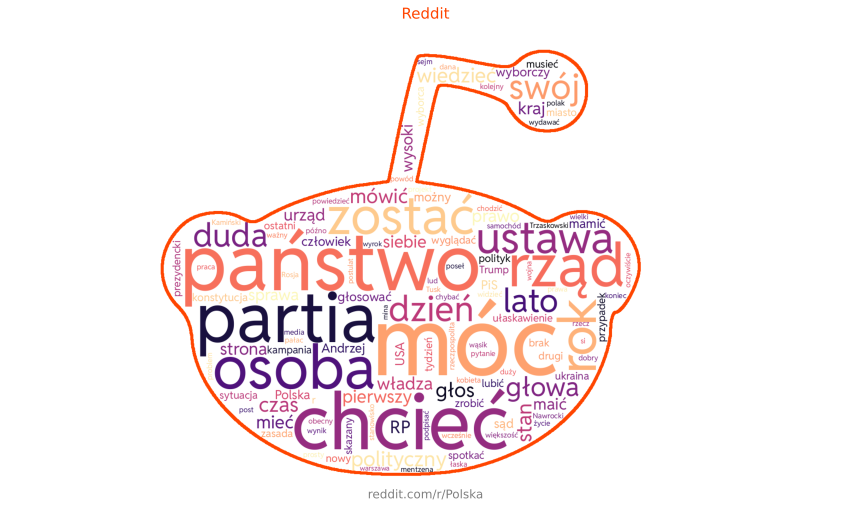

In [11]:
font_path = 'raport/img/RedditSans.ttf'
font_prop = font_manager.FontProperties(fname=font_path)
mask_path = 'raport/img/mask-reddit.png'  
mask = Image.open(mask_path)
mask = mask.convert("L")  # Convert to grayscale
mask = np.array(mask)

wc = WordCloud(font_path = font_path,
               mask=mask,
               width=1920, height=1080,
               background_color = "white",
               colormap = "magma",
               contour_width=12,
               contour_color='#ff4500')
wc.generate_from_frequencies(filtered_word_freq_reddit)

plt.figure(figsize=(15,12),dpi=300)
plt.axis('off')
plt.imshow(wc, interpolation="bilinear")
plt.title('Reddit', color='#ff4500', fontsize=15)
plt.text(0.5, 0.0, 'reddit.com/r/Polska', ha='center', va='center', fontsize=12, color='gray', transform=plt.gca().transAxes)
plt.show()

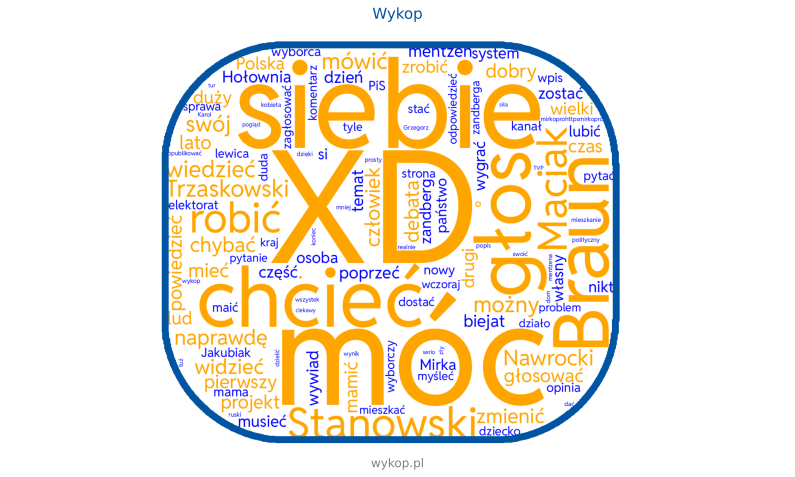

In [12]:
mask_path = 'raport/img/mask-wykop.png'  
mask = Image.open(mask_path)
mask = mask.convert("L")  # Convert to grayscale
mask = np.array(mask)


def orange_center_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Get the frequency of the word
    frequency = wc.words_.get(word, 0)
    
    # Assign orange to the most frequent words and blue to others
    if frequency > 0.3:  # Adjust this threshold based on your needs
        return "orange"
    else:
        return "blue"


wc = WordCloud(font_path = font_path,
               mask=mask,
               width=1920, height=1080,
               background_color = "white",
               color_func=orange_center_color_func,
               #colormap = "magma",
               contour_width=30,
               contour_color='#0054a2')
wc.generate_from_frequencies(filtered_word_freq_wykop)

plt.figure(figsize=(14,11),dpi=300)
plt.axis('off')
plt.imshow(wc, interpolation="bilinear")
plt.title('Wykop', color='#0054a2', fontsize=15)
plt.text(0.5, 0.0, 'wykop.pl', ha='center', va='center', fontsize=12, color='gray', transform=plt.gca().transAxes)
plt.show()

## Analiza sentymentu
Przechodzimy do właściwej analizy sentymentu.

In [13]:
# Dołączenie słownika sentymentu
df_reddit = df_reddit.merge(
    slownik_sentymentu,
    left_on='lemma_clean', 
    right_on='lemat',
    how='left'
)
df_wykop = df_wykop.merge(
    slownik_sentymentu,
    left_on='lemma_clean', 
    right_on='lemat',
    how='left'
)

# Zliczenie ilości słów o danym ładunku emocjonalnym
sentyment_suma_reddit = df_reddit.groupby('nachechowanie').size().reset_index(name='ilosc')
sentyment_suma_wykop = df_wykop.groupby('nachechowanie').size().reset_index(name='ilosc')

# Pominięcie słów bez przypisanego ładunku
sentyment_suma_reddit = sentyment_suma_reddit[sentyment_suma_reddit['nachechowanie'].notna()]
sentyment_suma_wykop = sentyment_suma_wykop[sentyment_suma_wykop['nachechowanie'].notna()]

Dołączamy słownik ładunków emocjonalnych do ostatecznie uzyskanej ramki danych i zliczamy wszystkie słowa o danym ładunku.

In [14]:
# Mapa kolorów i opisowych nazw dla skali emocji
custom_order = ['+ m', '+ s', 'amb', '- s', '- m']
label_map = {
    #      KOLOR       SENTYMENT
    '+ m': ['#2ecc40', 'bardzo pozytywny'],
    '+ s': ['#a3e048', 'pozytywny'],
    'amb': ['#ffd700', 'niejednoznaczny'],
    '- s': ['#ff8c00', 'negatywny'],
    '- m': ['#e74c3c', 'bardzo negatywny']
}

 Rezultat zostaje przedstawiony na wykresie lizakowym za pomocą biblioteki `matplotlib`.

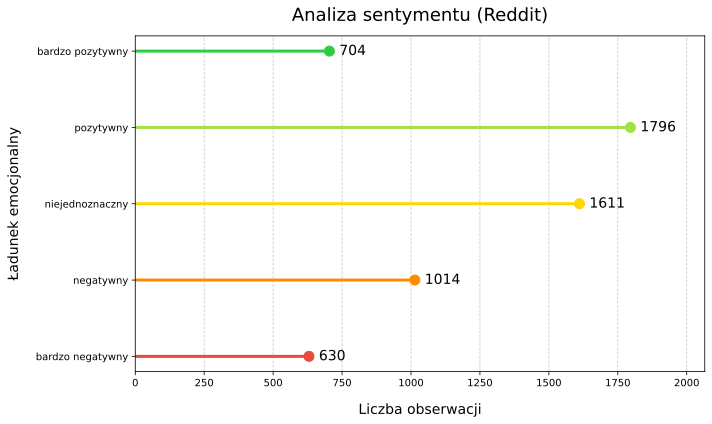

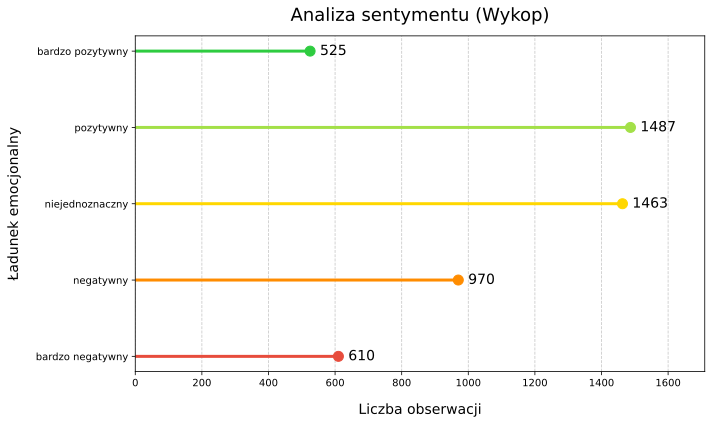

In [15]:
def analizator_sentymentu(platforma): 
    sentyment_suma = globals()[f'sentyment_suma_{platforma}']
    # Sortowanie 
    sentyment_suma['nachechowanie'] = pd.Categorical(
        sentyment_suma['nachechowanie'],
        categories=custom_order,
        ordered=True
    )
    sentyment_suma = sentyment_suma.sort_values('nachechowanie', ascending=False)
    # Przypisanie kolorów i nacechowania
    sentyment_suma['label'] = sentyment_suma['nachechowanie'].map(lambda x: label_map[x][1]) 
    sentyment_suma['color'] = sentyment_suma['nachechowanie'].map(lambda x: label_map[x][0])
    # Stworzenie wykresu
    plt.figure(figsize=(10, 6))
    for idx, row in sentyment_suma.iterrows():
        plt.hlines(
            y=row['label'],
            xmin=0,
            xmax=row['ilosc'],
            color=row['color'],
            linewidth=3
        )
        plt.plot(
            row['ilosc'],
            row['label'],
            'o',
            markersize=10,
            color=row['color']
        )
        plt.text(
            row['ilosc'] + max(sentyment_suma['ilosc']) * 0.02,
            row['label'],
            str(row['ilosc']),
            va='center',
            ha='left',
            fontsize=14,
            color='black'
        )  
    plt.title(f'Analiza sentymentu ({platforma.capitalize()})', fontsize=18, pad=15)
    plt.xlabel('Liczba obserwacji', labelpad=15, fontsize = 14)
    plt.ylabel('Ładunek emocjonalny', labelpad=15, fontsize = 14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    max_ilosc = sentyment_suma['ilosc'].max()
    plt.xlim(0, max_ilosc * 1.15)
    plt.tight_layout()
    plt.show()
analizator_sentymentu("reddit")
analizator_sentymentu("wykop")

## Wystąpienia poszczególnych kandydatów
Teraz skupimy się bezpośrednio na kwestii obecnych wyborów. Najpierw zliczymy ile razy wspomniano poszczególnych kandydatów, zliczając wystąpienia ich nazwisk odmienionych przez wszystkie przypadki

Minus tej metody: Internauci uwielbiają nadawać ksywki, których tutaj nie uwzględniamy.

In [16]:
df_kandydaci_r = df_reddit[['slowa']]
slownik_kandydaci = pd.read_csv('słowniki/slownik_kandydaci.csv', sep=',')
df_kandydaci_r = df_kandydaci_r.merge(
    slownik_kandydaci,
    left_on='slowa', 
    right_on='odmieniony',
    how='left'
)

count_kandydaci_r = pd.DataFrame({'Kandydaci': ['Trzaskowski', 'Nawrocki', 'Mentzen', 'Hołownia','Biejat',
 'Zandberg','Braun','Stanowski','Senyszyn','Jakubiak','Bartoszewicz','Woch','Maciak']})
Wystąpienia = df_kandydaci_r['mianownik'].value_counts()
count_kandydaci_r['Wystąpienia'] = count_kandydaci_r['Kandydaci'].map(Wystąpienia).fillna(0).astype(int)
kandydaci_posortowani_r = count_kandydaci_r.sort_values(by='Wystąpienia', ascending=False)
#print('Reddit:')
#print(kandydaci_posortowani_r)

df_kandydaci_w = df_wykop[['slowa']]
slownik_kandydaci = pd.read_csv('słowniki/slownik_kandydaci.csv', sep=',')
df_kandydaci_w = df_kandydaci_w.merge(
    slownik_kandydaci,
    left_on='slowa', 
    right_on='odmieniony',
    how='left'
)

count_kandydaci_w = pd.DataFrame({'Kandydaci': ['Trzaskowski', 'Nawrocki', 'Mentzen', 'Hołownia','Biejat',
 'Zandberg','Braun','Stanowski','Senyszyn','Jakubiak','Bartoszewicz','Woch','Maciak']})
Wystąpienia = df_kandydaci_w['mianownik'].value_counts()
count_kandydaci_w['Wystąpienia'] = count_kandydaci_w['Kandydaci'].map(Wystąpienia).fillna(0).astype(int)
kandydaci_posortowani_w = count_kandydaci_w.sort_values(by='Wystąpienia', ascending=False)
#print('Wykop:')
#print(kandydaci_posortowani_w)
print(type(count_kandydaci_r))

<class 'pandas.core.frame.DataFrame'>


## Wykres częstości wystąpień nazwisk kandydatów

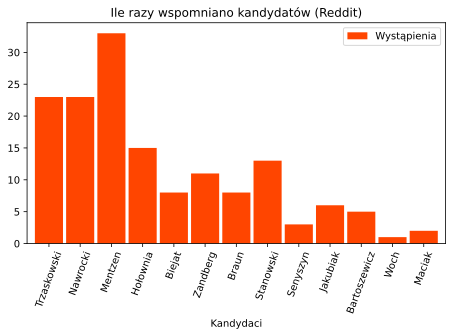

In [17]:
# tu będzie kod wykresu
count_kandydaci_r.plot.bar(x='Kandydaci', y='Wystąpienia', rot=0, width=0.9, color = '#ff4500', 
title = "Ile razy wspomniano kandydatów (Reddit)")
plt.xticks(rotation=70)                   
plt.tight_layout()                        
plt.show()

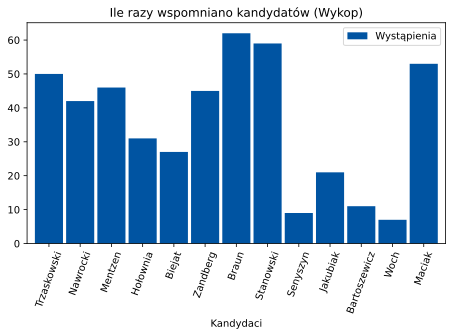

In [18]:
count_kandydaci_w.plot.bar(x='Kandydaci', y='Wystąpienia', rot=0, width=0.9, color = '#0054a2', 
title = "Ile razy wspomniano kandydatów (Wykop)")
plt.xticks(rotation=70)                   
plt.tight_layout()                        
plt.show()

## Asocjacje dla nazwisk kandydatów
Tym razem tekst musi zostać podzielony na całe wypowiedzi, a nie słowa.

In [21]:
import re
# Usuwanie listy wyrazow
pattern_words = r'\b(?:' + '|'.join(niechciane_slowa) + r')\b'

zmieniane = [
    # Zamiana "?" i "!" na kropki
    (r'[?!]', '.'),          
    # Usuwanie linków i hashtagów         
    (r'\bhttps?:\S*|#\w+|' + pattern_words, ''),
    # Usuwanie znaków specjalnych i liczb       
    (r'[{}]|\d+'.format(re.escape("''\"*,.:;>[]()%|<+=")), ''),
    # Zamiana / na spację
    (r'/', ' '),
    # Usuwanie wielokrotnych spacji                      
    (r'\s+', ' ')                     
]
for pattern, replacement in zmieniane:
    reddit_messy = re.sub(pattern, replacement, reddit_messy, flags=re.IGNORECASE)

reddit_messy = reddit_messy.strip()

wypowiedz_asoc_r = re.split(r'\s*-{50}\s*', reddit_messy)

Następnie dokonujemy lematyzacji i usunięcia stopwords z zachowaniem podziału na zdania.

In [22]:
# Funkcja do lematyzacji pojedynczego słowa
def lemmatize(word: str) -> str:
    try:
        analysis = morfeusz.analyse(word)
        if analysis:
            return analysis[0][2][1].split(':')[0]
        return word
    except:
        return word

# Lematyzacja zdań z zachowaniem struktury
asoc_lem_r = []
for wypowiedz in wypowiedz_asoc_r:
    # Dzielimy wypowiedz na słowa, lematyzujemy i łączymy z powrotem
    lematyzowane_slowa = [lemmatize(slowo) for slowo in wypowiedz.split()]
    asoc_lem_r.append(' '.join(lematyzowane_slowa))

# Usuwanie stopwords
def usun_stopwords(sentence, stopwords):
    words = sentence.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

asoc_lem_sw_r = [usun_stopwords(zdanie, df_polish_stop_words) for zdanie in asoc_lem_r]
#ostateczne wyczyszczenie z - i spacji
def clean_text_list(text_list):
    cleaned_list = []
    for text in text_list:
        text = re.sub(r'[„–”-]', '', text)
        text = re.sub(r'\s{2,}', ' ', text)
        text = text.strip()
        cleaned_list.append(text)
    return cleaned_list

asoc_lem_sw_c_r = clean_text_list(asoc_lem_sw_r)
# Zamiana na lowercase
asoc_gotowe_r = [zdanie.lower() for zdanie in asoc_lem_sw_c_r]

Macierz częstości słów

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(asoc_gotowe_r)
df_asoc_r = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
macierz_korelacji_r = df_asoc_r.corr(method='pearson')
# Funkcja znajdująca słowa najbardziej skorelowane z podanym słowem
def findAssocs(correlation_matrix, term, cor_limit=0.5):      
    if term not in correlation_matrix.columns:
        return f"Słowo '{term}' nie występuje"

    correlations = correlation_matrix[term]
    high_correlations = correlations[(correlations >= cor_limit) & 
                                   (correlations.index != term)]
    # Zwracane jest series z posortowanymi wartościami korelacji powyżej podanego progu
    return high_correlations.sort_values(ascending=False)

Wykresy asocjacji dla Reddita

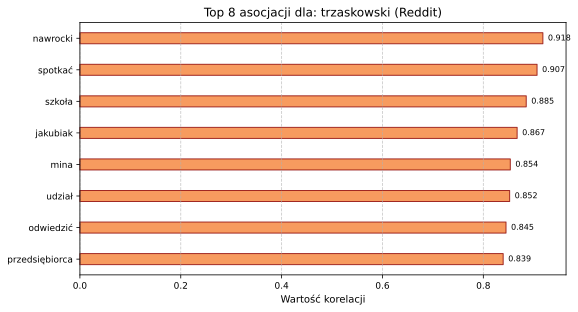

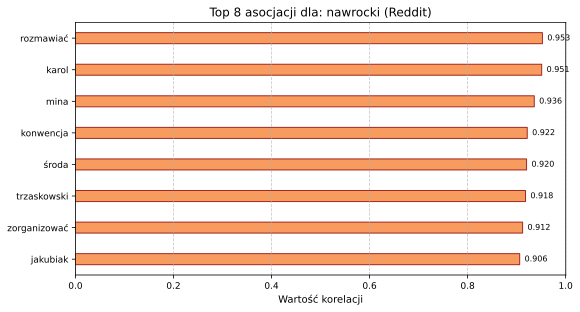

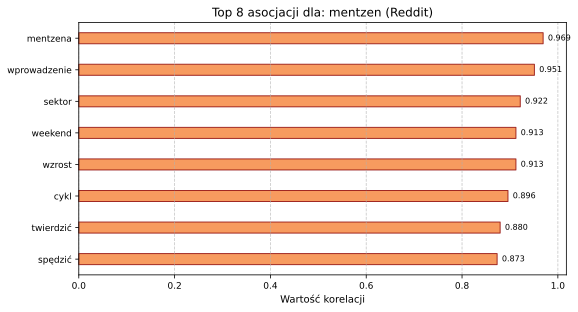

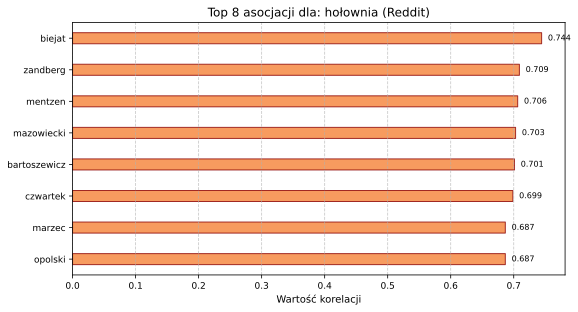

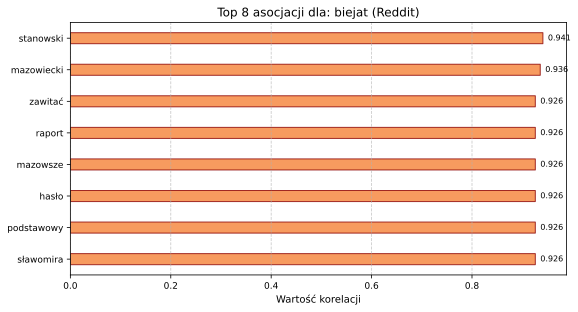

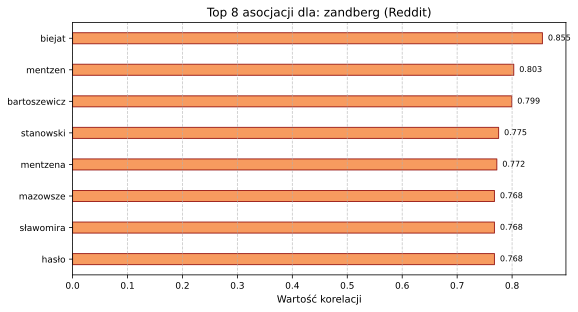

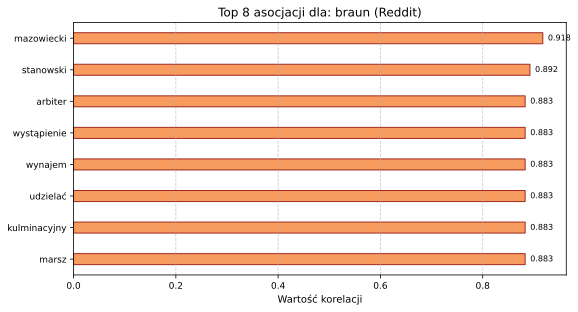

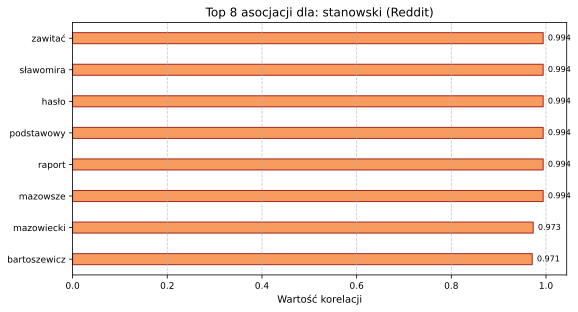

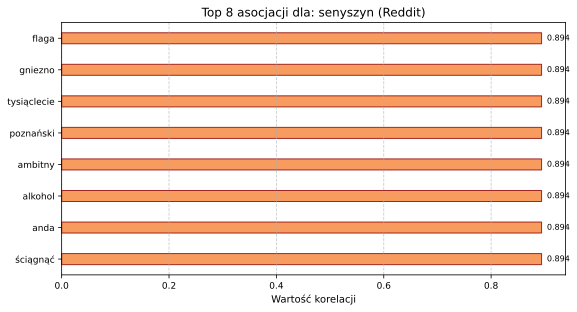

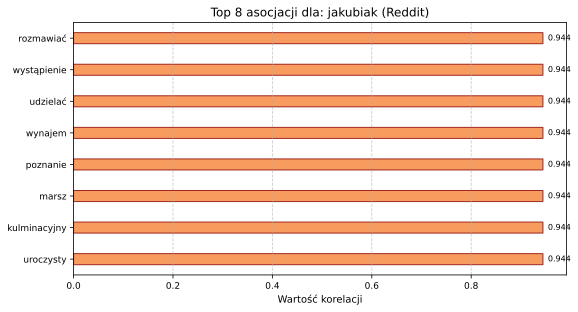

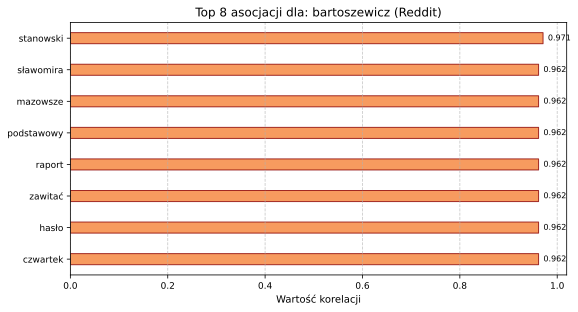

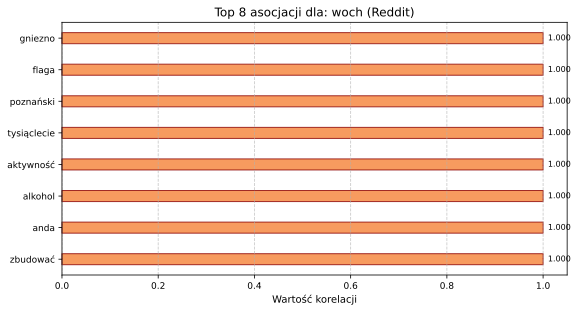

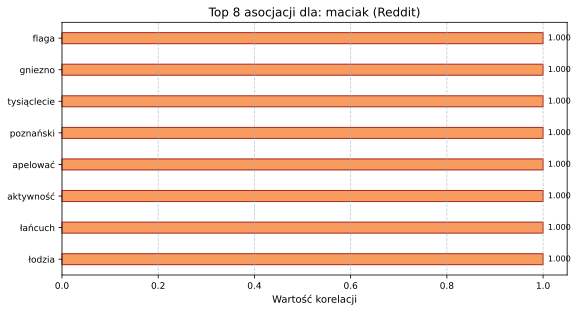

In [25]:
def asocjator1000(macierz, nazwisko, top_n):
    nazwisko_corr = findAssocs(macierz, nazwisko)

    # Ogranicz do `top_n` najwyższych korelacji
    nazwisko_corr = nazwisko_corr.nlargest(top_n)

    bar_height = 0.35
    fig_height = len(nazwisko_corr) * bar_height + 1.5
    fig, ax = plt.subplots(figsize=(8, fig_height))
    bars = ax.barh(
        y=nazwisko_corr.index,
        width=nazwisko_corr.values,
        height=bar_height,           
        color='#f58237',
        edgecolor='darkred',
        alpha=0.8
    )
    for bar in bars:
        width = bar.get_width()
        ax.text(
            width + 0.01,
            bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            va='center',
            fontsize=8
        )
   
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    ax.invert_yaxis()
    ax.set_ylim(len(nazwisko_corr) - 0.5, -0.5)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', labelsize=9)
    ax.set_title(f'Top {top_n} asocjacji dla: {nazwisko} (Reddit)', fontsize=12)
    ax.set_xlabel('Wartość korelacji', fontsize=10)
    plt.tight_layout(pad=0.5)

kandydaci = [nazwisko.lower() for nazwisko in count_kandydaci_r["Kandydaci"]]
asocjacje_top8 = [asocjator1000(macierz_korelacji_r, kandydat, 8) for kandydat in kandydaci]
